## Setup

In [2]:
%load_ext autoreload
%autoreload 2

from random import random
import pandas as pd
import matplotlib
import numpy as np
from sklearn import metrics
import csv
import time
import itertools
from dateutil.relativedelta import relativedelta

from alpha_vantage.timeseries import TimeSeries
import pandas_market_calendars as mcal


import pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from pathlib import Path
# import os
# current_path = os.getcwd()
# # top = Path(__file__ + '..').resolve()
import sys
# sys.path.insert(0, top/ 'code')
# sys.path.insert(0, top/ 'auth')
sys.path.insert(0, '../code')
sys.path.insert(0, '../auth')
sys.path.insert(0, '../')

# arrow = top / 'assets/arrow.png'
# print('source image:', arrow)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

Functions loaded.


# EDA

In [2]:
ts = TimeSeries(key=av_key, output_format='csv')
# AV_COLUMNS = ['time', '1. open', '2. high', '3. low', '4. close', '5. volume']
AV_COLUMNS = ['time', 'open', 'high', 'low', 'close', 'volume']

## Load Data

In [44]:
df_full = get_all_data_slices('SPY', ts, verbose=1)
df_full.to_csv('../data/SPY_2019_2021.csv')

Functions loaded.
Requesting all data slices for SPY...

Requesting slice: year1month1
First record:
                      open   high     low   close volume
time                                                    
2021-04-23 20:00:00  416.3  416.3  416.14  416.25  50513
Last record:
                       open    high     low   close volume
time                                                      
2021-03-29 05:00:00  394.03  394.03  393.19  393.68  87585
Processed and appended year1month1 to DataFrame.

Requesting slice: year1month2
First record:
                      open    high     low   close volume
time                                                     
2021-03-26 20:00:00  395.5  395.72  395.41  395.63  64946
Last record:
                              open           high            low  \
time                                                               
2021-02-25 05:00:00  390.618476937  390.618476937  389.870929457   

                             close volume  
time    

Re-requesting slice: year1month11
First record:
                              open           high            low  \
time                                                               
2020-06-29 20:00:00  302.148308716  302.464621926  301.831995507   

                            close  volume  
time                                       
2020-06-29 20:00:00  301.95061296  132030  
Last record:
                             open           high            low  \
time                                                              
2020-06-01 05:00:00  300.15733574  300.462413688  297.647823589   

                             close   volume  
time                                         
2020-06-01 05:00:00  299.055118638  1266371  
Processed and appended year1month11 to DataFrame.

Requesting slice: year1month12
First record:
                              open           high            low  \
time                                                               
2020-05-29 20:00:00  301.06272

Re-requesting slice: year2month9
Error: Header row length is 1, expected 6.
Sleeping for 11.57188898158261...
Re-requesting slice: year2month9
Error: Header row length is 1, expected 6.
Sleeping for 13.57066568799517...
Re-requesting slice: year2month9
Error: Header row length is 1, expected 6.
Sleeping for 13.28730165119911...
Re-requesting slice: year2month9
First record:
                              open           high            low  \
time                                                               
2019-09-03 20:00:00  281.742997671  281.839883159  281.326390075   

                             close volume  
time                                       
2019-09-03 20:00:00  281.413587014  53453  
Last record:
                              open           high            low  \
time                                                               
2019-08-05 05:00:00  280.677257309  280.677257309  279.611516946   

                             close volume  
time                    

In [4]:
# Get NYSE calendar
NYSE = mcal.get_calendar('NYSE')
early = NYSE.schedule(start_date='2012-07-01', end_date='2012-07-10')
early

,market_open,market_close
2012-07-02,2012-07-02 13:30:00+00:00,2012-07-02 20:00:00+00:00
2012-07-03,2012-07-03 13:30:00+00:00,2012-07-03 17:00:00+00:00
2012-07-05,2012-07-05 13:30:00+00:00,2012-07-05 20:00:00+00:00
2012-07-06,2012-07-06 13:30:00+00:00,2012-07-06 20:00:00+00:00
2012-07-09,2012-07-09 13:30:00+00:00,2012-07-09 20:00:00+00:00
2012-07-10,2012-07-10 13:30:00+00:00,2012-07-10 20:00:00+00:00


In [32]:
# ticker = 'SPY'
# date= 'year2month12'
# apiKey = av_key

# df_new = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol='+ticker+'&interval=60min&slice='+date+'&apikey='+apiKey+'&datatype=csv&outputsize=full') 

In [ ]:
# df_new.set_index('time', inplace=True)
# df_new.index = pd.to_datetime(df_new.index)

## Data Exploration

In [52]:
df_full.isna().sum()

Functions loaded.


open      311
high      311
low       311
close     311
volume    311
dtype: int64

## Set Proper Business Hour Frequency

In [17]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')

In [18]:
cbh

<CustomBusinessHour: CBH=05:00-21:00>

In [54]:
type(df_new)

pandas.core.frame.DataFrame

In [56]:
df_full = pd.read_csv('../data/SPY_2019_2021.csv', index_col='time')
df_full.index = pd.to_datetime(df_full.index)
try:
    assert(type(df_new)=='pandas.core.frame.DataFrame')
except AssertionError:
    print('Nothing to append')
else:
    df_full = df_full.append(df_new)
    df_full = df_full.sort_index()
    df_full = df_full.asfreq(cbh)
    df_full.to_csv('../data/SPY_2019_2021.csv')
finally:
    df_full = df_full.sort_index()
    df_full = df_full.asfreq(cbh)
    df_full.to_csv('../data/SPY_2019_2021.csv')
    df_full

Nothing to append


In [58]:
df = df_full.close
df

time
2019-05-07 05:00:00    281.033359
2019-05-07 06:00:00    280.956226
2019-05-07 07:00:00    280.483787
2019-05-07 08:00:00    280.136690
2019-05-07 09:00:00    280.368088
                          ...    
2021-04-23 16:00:00    416.720000
2021-04-23 17:00:00    416.250000
2021-04-23 18:00:00    416.360000
2021-04-23 19:00:00    416.330000
2021-04-23 20:00:00    416.250000
Freq: CBH, Name: close, Length: 8224, dtype: float64

In [ ]:
start = pd.to_datetime('2019-06-07')

In [ ]:
cbh.next_bday(pd.to_datetime(start))

In [ ]:
start + pd.DateOffset(days = 2)

In [ ]:
start + pd.offsets.BDay()

In [ ]:
df_copy = df_full.copy()
df_copy.index = df_copy.index.date
df_copy.index.value_counts()

In [ ]:
df_copy_2 = df_full2.copy()
df_copy_2.index = df_copy_2.index.date
df_copy_2.index.value_counts()

In [ ]:
df_full2[df_full2.index.date == pd.to_datetime('2020-07-06')]

In [ ]:
df_full[df_full.index.date == pd.to_datetime('2021-03-01')]

In [ ]:
null_data = df_full[df_full.isnull().any(axis=1)]
null_data

In [ ]:
null_data2 = df_full2[df_full2.isnull().any(axis=1)]
null_data2

In [ ]:
df_full.index

In [59]:
df.index

DatetimeIndex(['2019-05-07 05:00:00', '2019-05-07 06:00:00',
               '2019-05-07 07:00:00', '2019-05-07 08:00:00',
               '2019-05-07 09:00:00', '2019-05-07 10:00:00',
               '2019-05-07 11:00:00', '2019-05-07 12:00:00',
               '2019-05-07 13:00:00', '2019-05-07 14:00:00',
               ...
               '2021-04-23 11:00:00', '2021-04-23 12:00:00',
               '2021-04-23 13:00:00', '2021-04-23 14:00:00',
               '2021-04-23 15:00:00', '2021-04-23 16:00:00',
               '2021-04-23 17:00:00', '2021-04-23 18:00:00',
               '2021-04-23 19:00:00', '2021-04-23 20:00:00'],
              dtype='datetime64[ns]', name='time', length=8224, freq='CBH')

## Test out read and write CSV at same time

In [ ]:
with open('../data/GME_intra_Mar_29_Apr_12.csv', newline='') as csvfile:
#     fieldnames = ['first_name', 'last_name']
    reader = csv.reader(csvfile)
    fieldnames = next(reader)
    print(fieldnames)
    
    with open('../data/output.csv', mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(fieldnames)
        for row in reader:
            writer.writerow(row)
            

## More EDA

In [ ]:
y=1
m=11
data_slice = f'year{y+1}month{m+1}'
print(data_slice)
total_data_reader, total_meta_data = ts.get_intraday_extended(symbol='SPY', interval='60min', slice=data_slice)
fieldnames = next(total_data_reader)
print(fieldnames)
df_test = pd.DataFrame(total_data_reader, columns=fieldnames)
df_test.set_index('time', inplace=True)
df_test

In [ ]:
with open('../data/output.csv', mode='w', newline='') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=df_test_dict.keys())
#     writer = csv.DictWriter(sys.stderr, fieldnames=df_test_dict.keys())
#     writer = csv.writer(sys.stderr)
    writer = csv.writer(csvfile)
    writer.writerow(df_test.reset_index().columns)
#     writer.writeheader()
    writer.writerows(df_test.reset_index().values)

In [ ]:
df_test_close = df_test.close

# Data Prep

## Check Stationarity

In [60]:
test_stationarity(df.dropna())

Test Statistic                    0.008815
p-value                           0.959255
#Lags Used                       36.000000
Number of Observations Used    7876.000000
Critical Value (1%)              -3.431181
Critical Value (5%)              -2.861907
Critical Value (10%)             -2.566965
dtype: float64


In [61]:
test_stationarity(df.dropna(),1)

Test Statistic                -1.433867e+01
p-value                        1.069255e-26
#Lags Used                     3.600000e+01
Number of Observations Used    7.875000e+03
Critical Value (1%)           -3.431181e+00
Critical Value (5%)           -2.861907e+00
Critical Value (10%)          -2.566965e+00
dtype: float64


## Plot Seasonal Decomposition

In [ ]:
print(top)

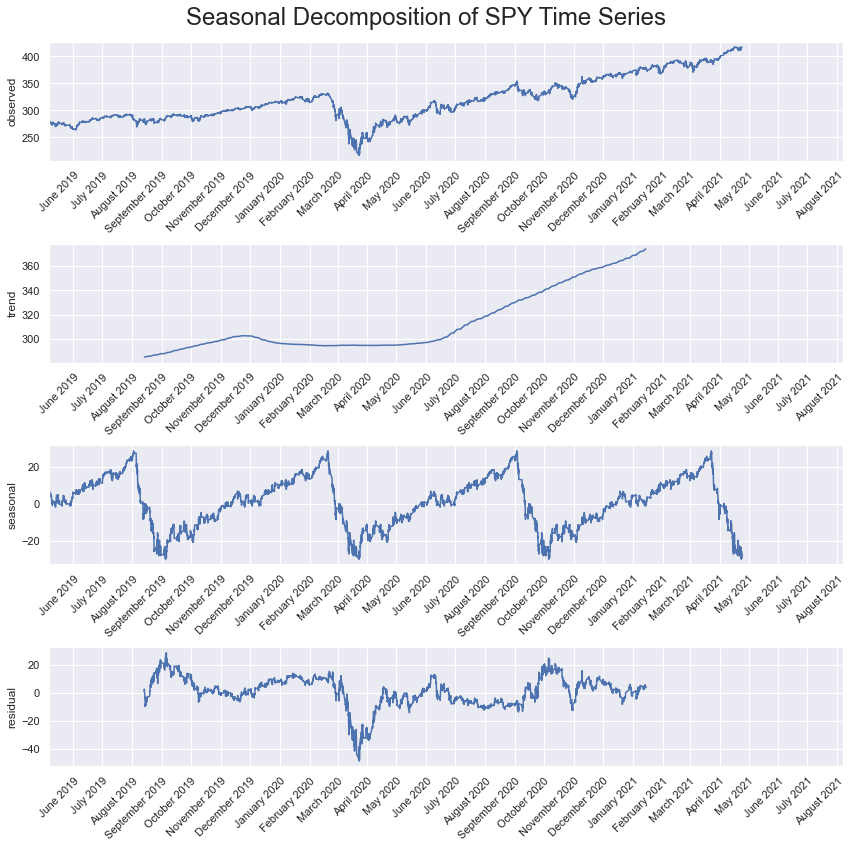

In [62]:
plot_seasonal_decomposition(df.dropna(), 'SPY')

# SARIMA Modeling

In [ ]:
round((80/100)*len(df))

In [64]:
df_train, df_test = train_test_split_data(df, 80)

Using a 80/20 train-test split...


In [ ]:
param_list = []
param_seasonal_list = []
aic_list = []

In [1]:
param = (2,1,0)
param_seasonal = (2,1,0,2190)

In [ ]:
au

In [ ]:
# mod = SARIMAX(df_train,
#               order=param,
#               seasonal_order=param_seasonal,
#               enforce_stationarity=False,
#               enforce_invertibility=False,
#               verbose=True).fit()
# param_list.append(param)
# param_seasonal_list.append(param_seasonal)
# aic = mod.aic

In [ ]:
# param_list, param_seasonal_list, aic_list = gridsearch_SARIMAX(df_train)

Functions loaded.
Parameters for SARIMAX grid search...
SARIMAX: (2, 1, 0) x (2, 1, 0, 2190)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


# Auto ARIMA

In [ ]:
auto